In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn	as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data	as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as	np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX	import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd


from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem	import QED
from rdkit.Chem	import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import	SimilarityMaps
from rdkit import Chem
from rdkit.Chem	import AllChem
from rdkit.Chem	import rdDepictor
from rdkit.Chem.Draw import	rdMolDraw2D
from numpy.polynomial.polynomial import	polyfit
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as	plt
from matplotlib	import gridspec
import matplotlib.cm as	cm
import matplotlib
#import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import	SVG, display
#import	sascorer
import itertools
from sklearn.metrics import	r2_score
import scipy

import operator,pybel
import os
#import setting
import warnings
try:
    from rdkit.Chem import AllChem
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import rdMolDraw2D
    from rdkit.Chem import rdDepictor
    import cairosvg
except:
    warnings.warn('Cannot import rdkit or cairosvg, so report is not supported')
    Chem = None
    setting.report_substructures = False

from scipy import stats
import operator
from cairosvg import svg2png

#then import my	own	modules
from AttentiveFP import	Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from IDLPPBopt.sarpy import SARpy
from IDLPPBopt.sarpy.SARpytools import *
from IDLPPBopt.config import DEFAULT_MODEL_PATH

# Related Functions

In [2]:
def eval_for_viz(model, viz_list,batch_size):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    mol_prediction_list = []
    atom_feature_list = []
    atom_weight_list = []
    mol_feature_list = []
    mol_feature_unbounded_list = []
    batch_list = []
    for i in range(0, len(viz_list), batch_size):
        batch = viz_list[i:i+batch_size]
        batch_list.append(batch)
    for counter, batch in enumerate(batch_list):
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(viz_list,get_smiles_dicts(batch))
        atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(
            torch.Tensor(x_atom), torch.Tensor(x_bonds),
            torch.cuda.LongTensor(x_atom_index),
            torch.cuda.LongTensor(x_bond_index),
            torch.Tensor(x_mask))
        #print(mol_attention_weight_viz[1].cpu().detach().numpy())
        mol_prediction_list.append(mol_prediction.cpu().detach().squeeze().numpy())
        atom_feature_list.append(np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)]))
        atom_weight_list.append(np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_list.append(np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_unbounded_list.append(np.stack([mol_feature_unbounded_viz[t].cpu().detach().numpy() for t in range(T)]))

    mol_prediction_array = np.concatenate(mol_prediction_list,axis=0)
    atom_feature_array = np.concatenate(atom_feature_list,axis=1)
    #print(atom_weight_list)
    atom_weight_array = np.concatenate(atom_weight_list,axis=1)
    #print(atom_weight_array)
    mol_feature_array = np.concatenate(mol_feature_list,axis=1)
    mol_feature_unbounded_array = np.concatenate(mol_feature_unbounded_list,axis=1)
#     print(mol_prediction_array.shape, atom_feature_array.shape, atom_weight_array.shape, mol_feature_array.shape)
    return mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array

def eval(model, dataset):
    model.eval()
#    eval_MAE_list = []
#    eval_MSE_list = []
#    y_val_list = []
    y_pred_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
#        y_val = batch_df[tasks[0]].values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
#        y_val_list.extend(y_val)
        y_pred_list.extend(np.array(mol_prediction.data.squeeze().cpu().numpy()))

#        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
#        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
#    r2 = r2_score(y_val_list,y_pred_list)
#    pr2 = scipy.stats.pearsonr(y_val_list,y_pred_list)[0]
    return y_pred_list

def get_smi_aw(remained_df):
    batch_size = len(remained_df.cano_smiles.values)
    train_df_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(remained_df.cano_smiles.values[m]),isomericSmiles=True) for m in range(0,batch_size)]
    mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array =  eval_for_viz(model_for_viz, train_df_smiles,batch_size)
    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(train_df_smiles,get_smiles_dicts(train_df_smiles))
    smi_aw = {}
    for i in range(batch_size):
        smiles = train_df_smiles[i]
        index_atom = smiles_to_rdkit_list[smiles]
        weight_recoder = np.stack([atom_weight_array[:,i][0][m] for m in np.argsort(index_atom)]) #1 is wrong
        atom_weight = [weight_recoder[m][0] for m in range(len(weight_recoder))]
        smi_aw[smiles] = atom_weight  #atom_weight
        #smi_ac[smiles] = np.sum(atom_weight)
    return smi_aw


def dataset(compounds):
    dataset = []
    for compound in compounds:
        compound = readstring('smi',compound)
        structure = Structure(compound)
        dataset.append(structure)
    return dataset

def collectSubs(structures, grinder):
    if not structures:
        return []
    substructures = []
    for structure in structures:
        substructures.extend(grinder.getFragments(structure))
    #print(fragments(substructures)) #substructures generate by each iteration
#    print('%s\tsubstructures found...' % len(substructures))
    return substructures + collectSubs(substructures, grinder)

def fragments(substructures):
    fragments = []
    for i in range(len(substructures)):
        fragments.append(substructures[i].smiles)
    return fragments


def drawmol(smiles, atom_weights,smarts=None):
    min_value = np.min(atom_weights)
    max_value = np.max(atom_weights)
    mean_value = np.mean(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
#    atom_weights = (atom_weights -mean_value)*1e3
    #print(atom_weights)
    #print(bg.number_of_nodes())
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28) #vmin=0.5 vmax=1.28
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm,cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))}
#    print(atom_weights[2])
    
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(700, 700)
    drawer.SetFontSize(0.6)
    op = drawer.drawOptions()
    bond_list = []
    bond_cols = {}
    if smarts:
        for smart in smarts:
            patt = Chem.MolFromSmarts(smart)
            atom_number = mol.GetSubstructMatch(patt)
            for bond in patt.GetBonds():
                aid1 = atom_number[bond.GetBeginAtomIdx()]
                aid2 = atom_number[bond.GetEndAtomIdx()]
                bond_list.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())
            colors = [(0.8,0,0),(0.8,0,0),(0.8,0,0)]            
            for bd in bond_list:
                bond_cols[bd] = colors[i%4]
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
#    print(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(len(atom_weights)),
                             highlightBonds=bond_list,
                             highlightAtomColors=atom_colors,
                             highlightBondColors = bond_cols)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
#     with open(str(smiles)+'.svg','w') as f:
#         f.write(svg)
    return svg

# Step 1. Prepare input file

In [3]:
task_name = 'ppb'
tasks = ['endpoint']

raw_filename = "input_compounds.csv"
feature_filename = raw_filename.replace('.csv','.pickle')

filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.cano_smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[0]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][0]), isomericSmiles=True)

number of all smiles:  4
number of successfully processed smiles:  4


# Step 2. Calculate molecule feature

In [4]:
feature_dicts = save_smiles_dicts(smilesList,filename)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print(str(len(uncovered_df.cano_smiles))+' compounds cannot be featured')
remained_df = remained_df.reset_index(drop=True)

feature dicts file saved as input_compounds.pickle
0 compounds cannot be featured


# Step 3. Load model

In [6]:
batch_size = 64
p_dropout= 0.1
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

best_model = torch.load(DEFAULT_MODEL_PATH)

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()

model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()

/home/david/miniconda3/envs/IDL-PPBopt/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. Saved a reverse patch to Linear.patch. Run `patch -p0 < Linear.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/david/miniconda3/envs/IDL-PPBopt/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. Saved a reverse patch to ModuleList.patch. Run `patch -p0 < ModuleList.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


tensor(True)

# Step 4. Predict values

In [7]:
remain_pred_list = eval(model, remained_df)
remained_df['Predicted_values'] = remain_pred_list
remained_df

,cano_smiles,Predicted_values
0,O=C(O)CC(c1ccccc1)n1ccc2cc(OCCc3ccc4c(n3)NCCC4...,0.970726
1,CN(C)Cc1cncc(C(CC(=O)O)n2ccc3cc(OCCc4ccc5c(n4)...,0.850634
2,CC(C)N1CN(C(c2ccccc2)c2ccccc2)n2ccc(=O)c(O)c2C1=O,0.946909
3,COCCN1CN(C(c2ccccc2)c2ccccc2)n2ccc(=O)c(O)c2C1=O,0.923631


In [8]:
remained_df.to_csv('temp.csv')

# Step 5. Get atom attention weights

In [9]:
# Notably: for more than 500 compounds, be cautious!
smi_aw = get_smi_aw(remained_df)
len(smi_aw)

4

# Step 6. Identify Privileged Substructure for each molecule

O=C(O)CC(c1ccccc1)n1ccc2cc(OCCc3ccc4c(n3)NCCC4)ccc21
[]
Predicted PPB fraction: 0.9707258343696594
Dectected Priviledged Substructures: []


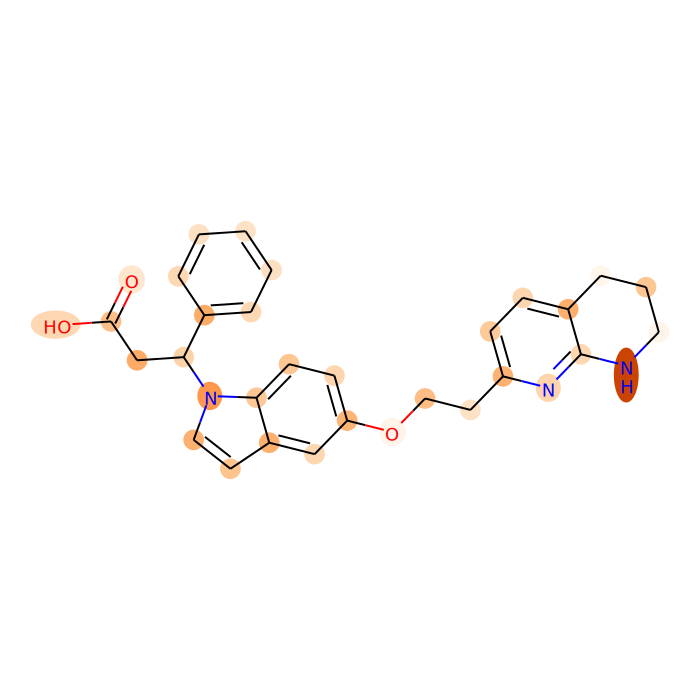

CN(C)Cc1cncc(C(CC(=O)O)n2ccc3cc(OCCc4ccc5c(n4)NCCC5)ccc32)c1
['*Cc1cncc(C(C*)*)c1']
Predicted PPB fraction: 0.8506335616111755
Dectected Priviledged Substructures: ['*Cc1cncc(C(C*)*)c1']


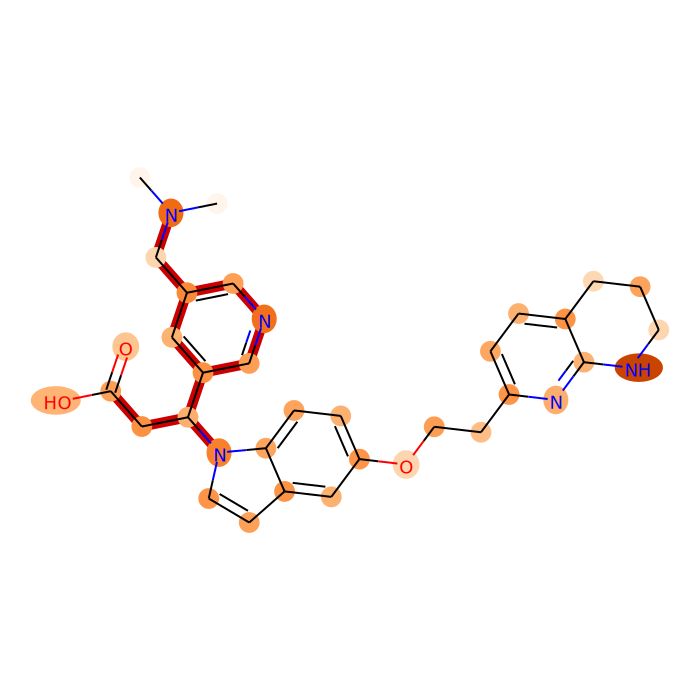

CC(C)N1CN(C(c2ccccc2)c2ccccc2)n2ccc(=O)c(O)c2C1=O
['CC(C)N1CN(*)n2ccc(=O)c(O)c2C1=O']
Predicted PPB fraction: 0.9469088315963745
Dectected Priviledged Substructures: ['CC(C)N1CN(*)n2ccc(=O)c(O)c2C1=O']


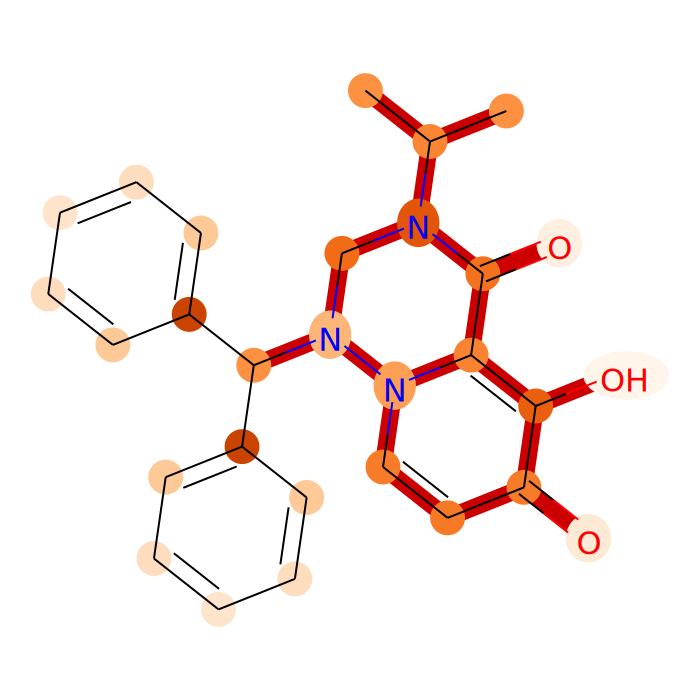

COCCN1CN(C(c2ccccc2)c2ccccc2)n2ccc(=O)c(O)c2C1=O
['COCCN1CN(*)n2ccc(=O)c(O)c2C1=O']
Predicted PPB fraction: 0.9236307144165039
Dectected Priviledged Substructures: ['COCCN1CN(*)n2ccc(=O)c(O)c2C1=O']


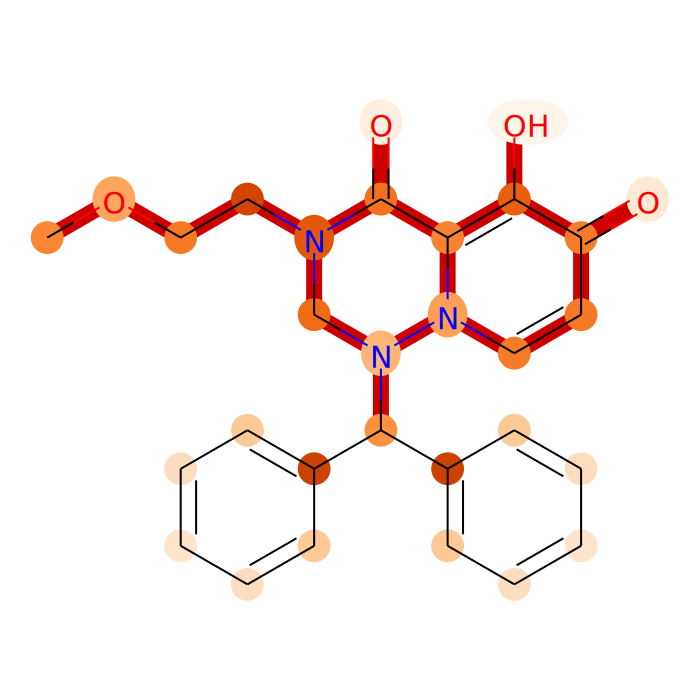

In [10]:
for key,value in smi_aw.items():
    print(key)
    grinder = Grinder(3,18)
    fragment_list = fragments(collectSubs(dataset([key]),grinder))
    psubs = []
    for fragment in fragment_list:
        patt = Chem.MolFromSmarts(fragment)
        smiles = Chem.MolFromSmiles(key)
        atom_numbers = smiles.GetSubstructMatches(patt)
        for j in range(len(atom_numbers)):
            fragment_atoms = [smi_aw[key][i] for i in atom_numbers[j]]
            rest_atoms = [smi_aw[key][i] for i in range(0,len(smi_aw[key]),1) if i not in atom_numbers[j]]
            if len(rest_atoms) < 3:
                pass
            else:
                try:
                    p_value = stats.mannwhitneyu(fragment_atoms,rest_atoms,alternative = 'greater')[1]
                    if p_value < 0.05:
                        psubs.append(fragment)
                except ValueError:
                    pass
    psubs_del = []
    for i in range(len(psubs)-1):
        for j in range(i+1,len(psubs)):
            patt1 = Chem.MolFromSmarts(psubs[i])
            patt2 = Chem.MolFromSmarts(psubs[j])
            smi1 = Chem.MolFromSmiles(psubs[i])
            smi2 = Chem.MolFromSmiles(psubs[j])
            frag1 = smi2.HasSubstructMatch(patt1)
            frag2 = smi1.HasSubstructMatch(patt2)
            if frag1 == True:
                if frag2 == False:
                    psubs_del.append(psubs[i])
            if frag1 == False:
                if frag2 == True:
                    psubs_del.append(psubs[j])
    psub = [p for p in psubs if p not in psubs_del]
    print(psub)
    print('Predicted PPB fraction: '+str(remained_df[remained_df.cano_smiles == key].Predicted_values.values[0]))
    print('Dectected Priviledged Substructures: ' +str(psub))
    svg = drawmol(key,value,psub)
    display(SVG(svg))

In [11]:
def eliminate_redundancy(frag_list,train_df_sort):
    Fragments = []
    for fragment in frag_list:
        elim_red_frag = {}
        elim_red_frag['Fragment'] = fragment
        patt = Chem.MolFromSmarts(fragment)
        Get_smiles_index = []
        for key in train_df_sort.cano_smiles:
            smiles = Chem.MolFromSmiles(key)
            frag = smiles.HasSubstructMatch(patt)
            if frag == True:
                Get_smiles_index.append(train_df_sort[train_df_sort.cano_smiles == key].index.tolist()[0])
            else:
                pass
        elim_red_frag['smiles_index'] = list(set(Get_smiles_index))
        Fragments.append(elim_red_frag)
#    print(Fragments)
    Fragments_del_list = []
    for i in range(len(Fragments)-1):
        for j in range(i+1,len(Fragments)):
            if Fragments[i]['smiles_index'] == Fragments[j]['smiles_index']:
                patt1 = Chem.MolFromSmarts(Fragments[i]['Fragment'])
                patt2 = Chem.MolFromSmarts(Fragments[j]['Fragment'])
                smiles1 = Chem.MolFromSmiles(Fragments[i]['Fragment'])
                smiles2 = Chem.MolFromSmiles(Fragments[j]['Fragment'])
                frag1 = smiles2.HasSubstructMatch(patt1)
                frag2 = smiles1.HasSubstructMatch(patt2)
                if frag1 == True:
                    if frag2 == False:
                        Fragments_del_list.append(Fragments[i]['Fragment'])
                if frag2 == True:
                    if frag1 == False:
                        Fragments_del_list.append(Fragments[j]['Fragment'])
                if frag1 == False:
                    if frag2 == False:
                        pass
    Final_Fragments_list = [f for f in frag_list if f not in Fragments_del_list]
    return Final_Fragments_list

def get_virtual_index(patt):
    i = 0
    virtual_index = []
    for atom in patt.GetAtoms():
        if atom.GetSymbol() != '*':
            virtual_index.append(i)
        i += 1
    return virtual_index


def get_R_virtual_index(patt):
    i = 0
    virtual_index = []
    for atom in patt.GetAtoms():
        if atom.GetSymbol() == '*':
            virtual_index.append(i)
        i += 1
    return virtual_index

def Find_second_level_substructures(SAs_list,train_df_sort):
    result = []
    for subs in SAs_list:
        subs_smiles_list = []
        non_toxicity_SAs = []
        non_toxicity_SAs_values = {}
        match_compounds_numb = 0
        patt = Chem.MolFromSmarts(subs)
        for key in train_df_sort.cano_smiles:
            smiles = Chem.MolFromSmiles(key)
            frag = smiles.HasSubstructMatch(patt)
            if frag == True:
                match_compounds_numb +=1
                subs_smiles_list.append(key)
        print(str(subs) + ' matches ' + str(match_compounds_numb)+' compounds')
        grinder = Grinder(3,18)
        subs_fragment = fragments(collectSubs(dataset(subs_smiles_list),grinder))
        print('Totally find ' + str(len(subs_fragment)) + ' fragments')
        for sub in subs_fragment:
            sub_patt = Chem.MolFromSmarts(sub)
            compounds_contain_activity = []
            compounds_no_contain_activity = []
            for smi in subs_smiles_list:
                smile = Chem.MolFromSmiles(smi)
                frags = smile.HasSubstructMatch(sub_patt)
                if frags == True:
                    activity = train_df_sort[train_df_sort.cano_smiles == smi].endpoint.values[0]
                    compounds_contain_activity.append(activity)
                else:
                    inactivity = train_df_sort[train_df_sort.cano_smiles == smi].endpoint.values[0]
                    compounds_no_contain_activity.append(inactivity)
#           print('compounds contain '  + str(sub)+ ' is ' + str(len(compounds_contain_activity)))
            if len(compounds_contain_activity) < 5:
                pass
            elif len(compounds_no_contain_activity) < 5:
                pass
            elif len(compounds_contain_activity)/len(compounds_no_contain_activity) > 4:
                pass
            elif len(compounds_no_contain_activity)/len(compounds_contain_activity) > 4:
                pass
            else:
#               P_value = stats.mannwhitneyu(compounds_contain_activity,compounds_no_contain_activity,alternative = 'less')[1]  #'less' non_toxic
                P_value = stats.mannwhitneyu(compounds_contain_activity,compounds_no_contain_activity)[1]
                if P_value < 0.01:
                    non_toxicity_SAs.append(sub)
                    va = np.mean(compounds_contain_activity) - np.mean(compounds_no_contain_activity)
                    non_toxicity_SAs_values[sub] = va
#                    draw_violin(compounds_contain_activity,compounds_no_contain_activity)
                    #print('None_toxicity_SAs: '    + str(sub) + ' number of compounds contain SAs & not : '+ str(len(compounds_contain_activity)) + ':' + str(len(compounds_no_contain_activity)))
                else:
                    pass
        # Inside Molecule analysis
        subs_smiles_list_df = pd.DataFrame(data = subs_smiles_list,columns = ['cano_smiles'])
        non_toxicity_SAs1 = eliminate_redundancy(non_toxicity_SAs,subs_smiles_list_df)
        print('For ' + str(subs)+' totally find '+ str(len(non_toxicity_SAs1))+ ' second-level substructures!')
        for subss in non_toxicity_SAs1:
            SAs_Non_SAs = {}
            SAs_Non_SAs['SA'] = subs
            SAs_Non_SAs['Non_SAs'] = subss
            SAs_Non_SAs['score'] = non_toxicity_SAs_values[subss]
            non_toxic_patt = Chem.MolFromSmarts(subss)
            no_SA_R_index = get_R_virtual_index(non_toxic_patt)
            stat1 = [[m] for m in range(len(no_SA_R_index))]
            stat2 = []
            RES = 0
            CES = 0
            NTS = 0
            ZES = 0
            for smiss in subs_smiles_list:
                ssmile = Chem.MolFromSmiles(smiss)
                ffrag = ssmile.HasSubstructMatch(non_toxic_patt)
                if ffrag == True:
                    atom_numbers_SAs = ssmile.GetSubstructMatches(patt)
                    atom_numbers_non_SAs = ssmile.GetSubstructMatches(non_toxic_patt)
                    SA_index = get_virtual_index(patt)
                    no_SA_index = get_virtual_index(non_toxic_patt)
                    for j in range(len(atom_numbers_non_SAs)):
                        no_SA_distance_index = [atom_numbers_non_SAs[j][n] for n in no_SA_index]
                        atom_index = [atom_numbers_non_SAs[j][m] for m in no_SA_R_index]
                        for n in range(len(atom_index)):
                            atom = ssmile.GetAtomWithIdx(atom_index[n]).GetSymbol()
                            stat1[n].append(atom)
                        for i in range(len(atom_numbers_SAs)):
                            SA_distance_index = [atom_numbers_SAs[i][m] for m in SA_index]
                            distance = Chem.GetDistanceMatrix(ssmile)
                            subs_distance = np.array(distance[SA_distance_index,:][:,no_SA_distance_index])
                            if subs_distance.min() == 0:
                                RES += 1
                            elif subs_distance.min() == 1:
                                CES += 1 
                            elif subs_distance.min() <= 3:
                                ZES += 1
                            else:
                                NTS += 1
            SAs_Non_SAs['RES'] = RES
            SAs_Non_SAs['CES'] = CES
            SAs_Non_SAs['NTS'] = NTS
            SAs_Non_SAs['ZES'] = ZES
            for x in range(len(stat1)):
                stat3 = {}
                for y in stat1[x]:
                    stat3[y] = stat1[x].count(y)
                stat2.append(stat3)
            SAs_Non_SAs['R_group'] = stat2
            result.append(SAs_Non_SAs)
    return result

In [12]:
target = 'ppb_3922'
df = pd.read_csv(target+'.csv')
molset = [Chem.MolFromSmiles(smi) for smi in df.cano_smiles]
train_df = df[df.set_split == 'train'].drop('set_split',axis=1).reset_index(drop= True)
smi_list = [smi for smi in train_df.cano_smiles]
train_df_sort = train_df.sort_values(by = 'endpoint',ascending = False).reset_index(drop=True)

In [13]:
SA = ['CN1CC(*)C1']
r = Find_second_level_substructures(SA,train_df_sort)

CN1CC(*)C1 matches 125 compounds
Totally find 5062 fragments
For CN1CC(*)C1 totally find 8 second-level substructures!


In [15]:
with open('Results.smi','w') as f:
    f.write('SA_Fragment\tNAS\tScore\tRES\tCES\tZES\tNTS\n')
    for	i in range(len(r)):
        f.write(str(r[i]['SA']) + '\t' + \
                str(r[i]['Non_SAs']) + '\t' + \
                str(r[i]['score']) + '\t' + \
                str(r[i]['RES']) + '\t' + \
                str(r[i]['CES']) + '\t' + \
                str(r[i]['ZES']) + '\t' + \
                str(r[i]['NTS']) + '\n')